# Task 1: EDA & Preprocessing – CFPB Consumer Complaints
Goal: Understand data, filter to 5 products, clean narratives

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nicer
%matplotlib inline
plt.style.use('seaborn-v0_8')   # or just 'seaborn' if that doesn't work
sns.set_palette("viridis")

In [ ]:
# Cell 2 - Load the data and show basic info
DATA_PATH = "../data/raw/cfpb_complaints.csv"          # <--- change here if needed

df = pd.read_csv(DATA_PATH, low_memory=False)          # low_memory=False helps with mixed types

print("Shape (rows, columns):", df.shape)
print("\nColumns:")
print(df.columns.tolist())

print("\nFirst 3 rows preview:")
display(df.head(3))

print("\nData types and non-null counts:")
display(df.info(verbose=False))

In [ ]:
# Count Missing Narratives
df["Consumer complaint narrative"].isna().sum()

np.int64(6629041)

In [ ]:
df.shape[0]

9609797

In [ ]:
# Calculate Percentage Missing (Simple)
missing_pct = df["Consumer complaint narrative"].isna().mean() * 100
missing_pct

np.float64(68.98211273349479)

In [ ]:
# create a copy of the dataframe with text narratives only
df_with_text = df[df["Consumer complaint narrative"].notna()].copy()
print("Shape of dataframe with text narratives:", df_with_text.shape)

Shape of dataframe with text narratives: (2980756, 18)


In [ ]:
# Top 10 Products with Text Narratives
df_with_text["Product"].value_counts().head(10)

Product
Credit reporting or other personal consumer reports                             1091253
Credit reporting, credit repair services, or other personal consumer reports     807281
Debt collection                                                                  336076
Checking or savings account                                                      140319
Mortgage                                                                         130160
Credit card or prepaid card                                                      108667
Money transfer, virtual currency, or money service                                97188
Credit card                                                                       80667
Student loan                                                                      53209
Vehicle loan or lease                                                             39577
Name: count, dtype: int64

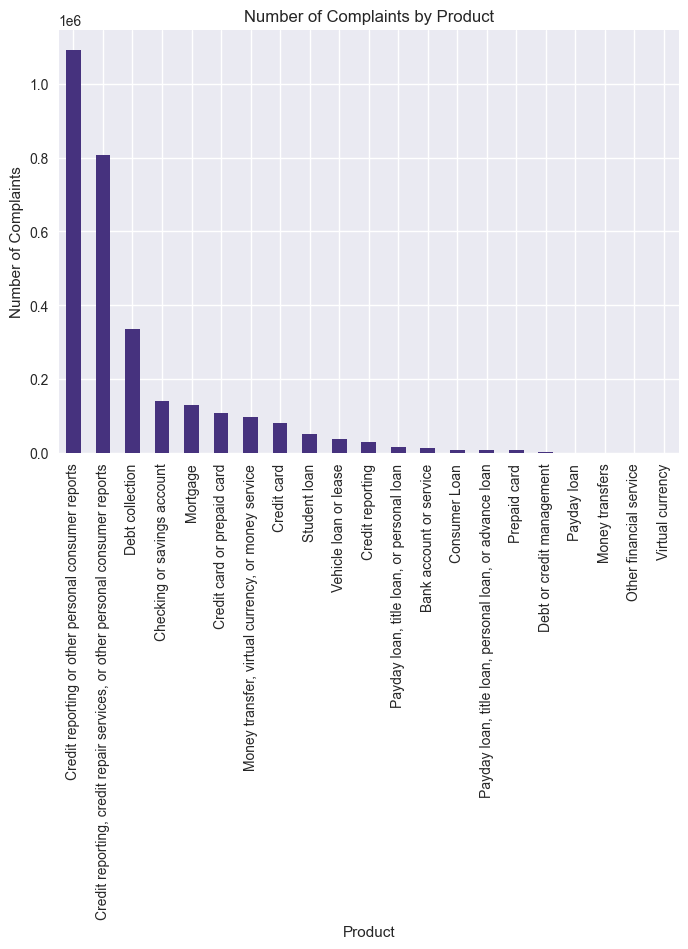

In [ ]:
# Plot Number of Complaints by Product
import matplotlib.pyplot as plt

product_counts = df_with_text["Product"].value_counts()

plt.figure()
product_counts.plot(kind="bar")
plt.title("Number of Complaints by Product")
plt.xlabel("Product")
plt.ylabel("Number of Complaints")
plt.show()


In [ ]:
# Analyze Narrative Length
# Create a Word Count Column called n_words
df_with_text["n_words"] = df_with_text["Consumer complaint narrative"].str.split().str.len()
df_with_text[["Consumer complaint narrative", "n_words"]].head()


,Consumer complaint narrative,n_words
76,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX Apt XX...,317
359,Subject : Dispute of Unauthorized Hard Inquiri...,447
11499,I signed a purchase agreement with Lennar Corp...,273
11973,"After checking my report, I found numerous acc...",112
12237,A XXXX XXXX card was opened under my name by a...,91


In [ ]:
df_with_text["n_words"].describe()

count    2.980756e+06
mean     1.755976e+02
std      2.259282e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.140000e+02
75%      2.090000e+02
max      6.469000e+03
Name: n_words, dtype: float64

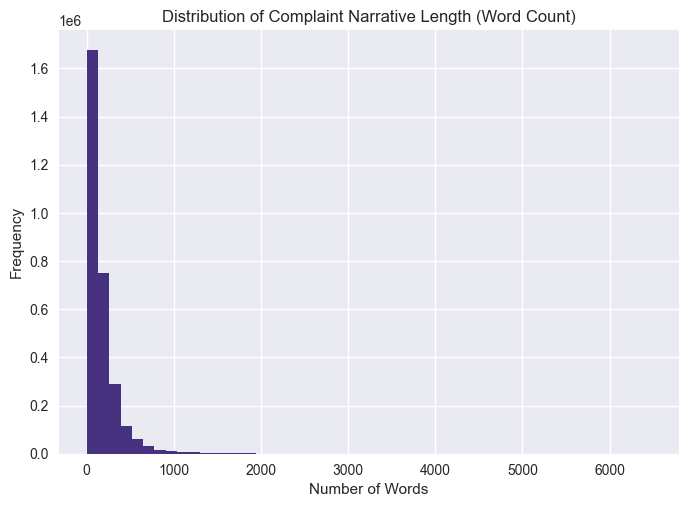

In [ ]:
plt.figure()
df_with_text["n_words"].hist(bins=50)
plt.title("Distribution of Complaint Narrative Length (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


Most consumer complaint narratives are medium-length, with a median of approximately 114 words and the majority falling between 50 and 200 words. However, there are notable outliers with very long narratives exceeding 1,000 words. This variability motivates the use of text chunking in later stages of the RAG pipeline to ensure consistent embedding quality and effective retrieval.

In [ ]:
# Filter to the Five Required Products
# Define the list of products to keep
target_products = [
    "Credit card",
    "Personal loan",
    "Buy Now, Pay Later (BNPL)",
    "Savings account",
    "Money transfers"
]
# filter the dataframe
df_filtered = df_with_text[df_with_text["Product"].isin(target_products)].copy()
print("Shape of filtered dataframe:", df_filtered.shape)

# Check Distribution After Filtering
df_filtered["Product"].value_counts()

Shape of filtered dataframe: (82164, 19)


Product
Credit card        80667
Money transfers     1497
Name: count, dtype: int64

In [ ]:
# Inspect Unique Product Names
df_with_text["Product"].value_counts().head(30)


Product
Credit reporting or other personal consumer reports                             1091253
Credit reporting, credit repair services, or other personal consumer reports     807281
Debt collection                                                                  336076
Checking or savings account                                                      140319
Mortgage                                                                         130160
Credit card or prepaid card                                                      108667
Money transfer, virtual currency, or money service                                97188
Credit card                                                                       80667
Student loan                                                                      53209
Vehicle loan or lease                                                             39577
Credit reporting                                                                  31587
Payday loan, title loan,

In [ ]:
# Map CFPB Product Names to Project Products
product_mapping = {
    "Credit card": [
        "Credit card",
        "Credit card or prepaid card",
        "Prepaid card"
    ],
    "Personal loan": [
        "Personal loan",
        "Consumer Loan",
        "Payday loan, title loan, or personal loan",
        "Payday loan, title loan, personal loan, or advance loan",
        "Student loan",
        "Vehicle loan or lease"
    ],
    "Savings account": [
        "Checking or savings account",
        "Bank account or service"
    ],
    "Money transfers": [
        "Money transfers",
        "Money transfer, virtual currency, or money service"
    ]
}


In [ ]:
# Now flatten the values:
allowed_products = [p for products in product_mapping.values() for p in products]

df_filtered = df_with_text[df_with_text["Product"].isin(allowed_products)].copy()
df_filtered.shape

(579396, 19)

In [ ]:
# Add a Unified Product Category
# clean categories for retrieval
def map_product(product):
    for key, values in product_mapping.items():
        if product in values:
            return key
    return "Other"

df_filtered["product_category"] = df_filtered["Product"].apply(map_product)

df_filtered["product_category"].value_counts()


product_category
Credit card        197126
Savings account    155204
Personal loan      128381
Money transfers     98685
Name: count, dtype: int64

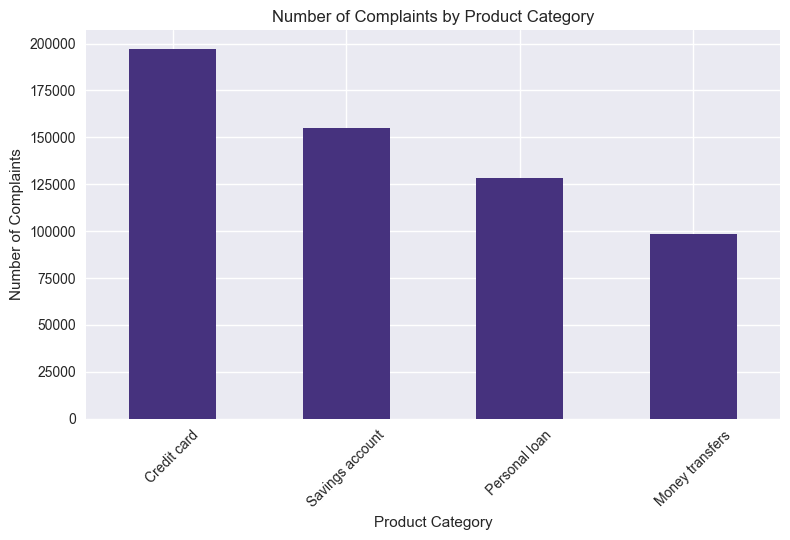

In [ ]:
# Plot Number of Complaints by Product After Filtering
import matplotlib.pyplot as plt
product_counts = df_filtered["product_category"].value_counts()
product_counts.plot(kind="bar", title="Number of Complaints by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Create a Clean Text Column
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)  # remove extra whitespace
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove special characters
    return text.strip()

df_filtered["clean_narrative"] = df_filtered["Consumer complaint narrative"].apply(clean_text)


In [ ]:
# Quick Sanity Check
df_filtered[["Consumer complaint narrative", "clean_narrative"]].head(4)

,Consumer complaint narrative,clean_narrative
12237,A XXXX XXXX card was opened under my name by a...,a xxxx xxxx card was opened under my name by a...
12532,I made the mistake of using my wellsfargo debi...,i made the mistake of using my wellsfargo debi...
13280,"Dear CFPB, I have a secured credit card with c...",dear cfpb i have a secured credit card with ci...
13506,I have a Citi rewards cards. The credit balanc...,i have a citi rewards cards the credit balance...


In [ ]:
# Save the Final Dataset
df_filtered.to_csv(
    "../data/processed/filtered_complaints.csv",
    index=False
)


In this task, we explored the CFPB consumer complaint dataset and assessed its suitability for a retrieval-augmented generation (RAG) system.
Approximately 69% of complaints lacked consumer narratives and were removed, leaving a substantial corpus of text-based complaints.
Analysis of narrative length showed that most complaints are medium-length, with a median of around 114 words, alongside a small number of very long outliers, motivating the use of text chunking in later stages.

The dataset was filtered and mapped to four relevant product categories—Credit Card, Personal Loan, Savings Account, and Money Transfers—based on CFPB product labels.
Buy Now, Pay Later (BNPL) complaints were not explicitly identifiable in the dataset, which is noted as a limitation.
The resulting cleaned dataset was saved for use in downstream embedding, retrieval, and RAG pipeline development.